## Import Libraries

In [1]:
import cv2
import pandas as pd
import numpy as np
import time
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.optimizers import Adam
from display import heatmap_display
from occlusion_sensitivity import OcclusionSensitivity



## Load the Model

In [2]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [3]:
optimizer = Adam(lr=0.001)
lr_metric = get_lr_metric(optimizer)

In [4]:
model = tensorflow.keras.models.load_model('model.h5', custom_objects={'lr': lr_metric})
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

## Load the Dataset

In [5]:
train_data_dir = os.path.join(os.getcwd(), 'train_df.csv')
print('train_data_dir', train_data_dir)

train_df = pd.read_csv(train_data_dir)

val_data_dir = os.path.join(os.getcwd(), 'val_df.csv')
print('val_data_dir', val_data_dir)
                        
val_df = pd.read_csv(val_data_dir)

train_data_dir D:\Uni_Freiburg\master_thesis\skin_lesions\train_df.csv
val_data_dir D:\Uni_Freiburg\master_thesis\skin_lesions\val_df.csv


In [6]:
num_train_samples = len(train_df)
num_val_samples = len(val_df)

train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

In [7]:
datagen = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                           target_size=(image_size,image_size),
                                           batch_size=1,
                                           shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [8]:
model.evaluate(test_batches, 
               steps=len(val_df),
               verbose = 2)

  ...
    to  
  ['...']
938/938 - 31s - loss: 1.2885 - accuracy: 0.6343 - lr: 9.9999e-04


[1.288467427823635, 0.63432837, 0.000999991]

In [9]:
classes = ['Actinic keratoses',
           'Basal Cell Carcinoma',
           'Benign keratosis',
           'Dermatofibroma',
           'Melanocytic Nevi',
           'Melanoma', 
           'Vascular Lesions']

## Implementation of Occlusion Sensitivity Method

In [10]:
sampleids = [1, 12, 17, 4, 2, 10, 4] # random numbers

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


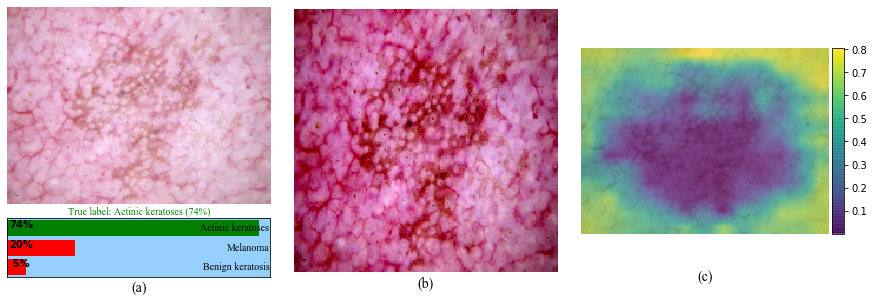

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


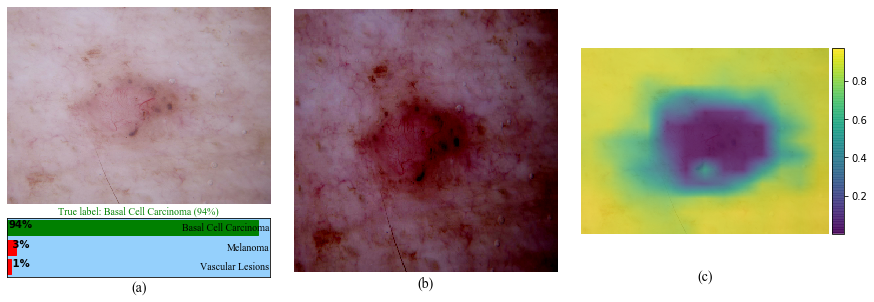

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


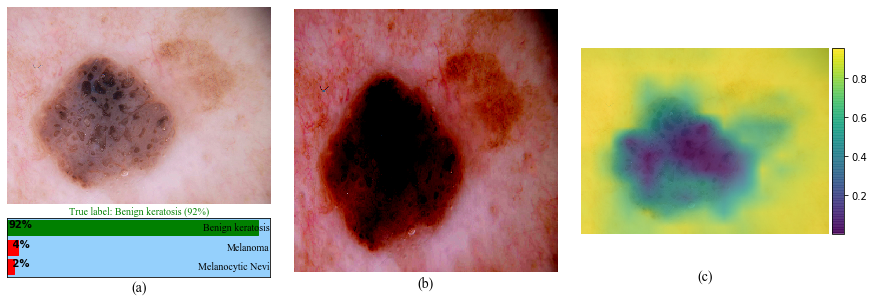

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


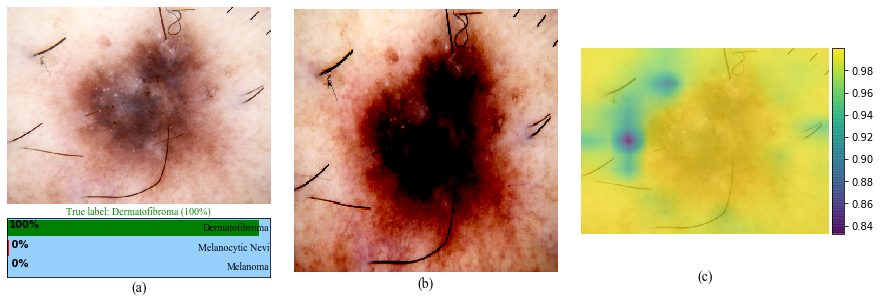

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


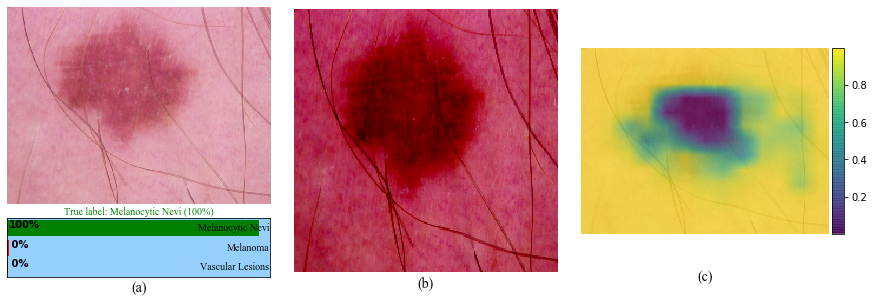

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


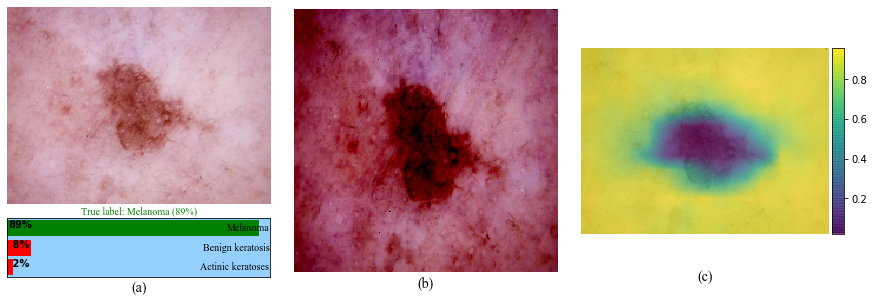

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


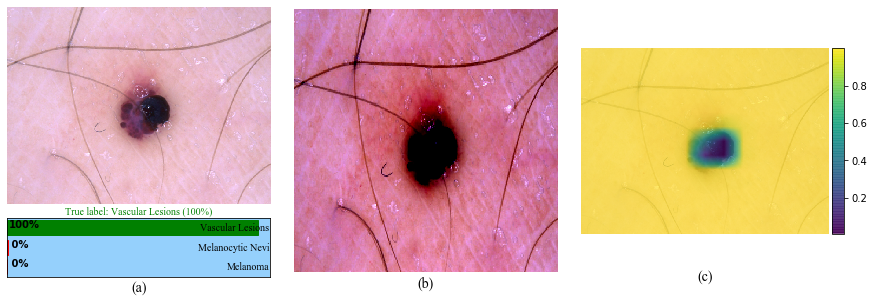

In [11]:
labels = ['akk', 'bcc', 'bkl', 'df', 'mcy', 'mel', 'vasc']

explainer = OcclusionSensitivity()
patch_size = 32
occluding_stride = 16
occluding_pixel = 0.5

for classid in range(7):
    
    idx =  val_df['cell_type_idx']==classid
    df_val = val_df[idx]
    sampleid = sampleids[classid]
    
    image_path = df_val.iloc[sampleid]['path']
    correct_class = df_val.iloc[sampleid]['cell_type_idx']
    
    original_img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(original_img, (224,224))
    
    aug_img = next(datagen.flow(np.expand_dims(img, axis = 0), batch_size=1, shuffle=False))
    predicted_class = model.predict(aug_img)[0]

    sensitivity_map1 = explainer.explain(original_img = original_img,
                                                      aug_img = aug_img[0],
                                                      model = model,
                                                      class_index = correct_class,
                                                      patch_size = patch_size,
                                                      occluding_stride = occluding_stride,
                                                      occluding_pixel = occluding_pixel
                                                     )
    
    save_name = '{}_{}_os.svg' .format(labels[correct_class], sampleid)

                    
    heatmap_display(predictions_array = predicted_class,
                    true_label = correct_class,
                    original_img = original_img,
                    aug_img = aug_img[0],
                    heatmap = sensitivity_map1,
                    classes = classes,
                    k = 3,
                    # save_name = save_name
                    )
    